In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
# Input stimulus Generator

# Input stimulus

def Id(t, vtime1,vtime2):
        if vtime1< t < vtime2:
            return 10.0
        else:
            return 0.0

def input(tmax, vtime1, vtime2):
    

    # Start and end time (in milliseconds)
    tmin = 0.0

    T = np.linspace(tmin, tmax, 10000)

    #Idv = [Id(t)+np.random.normal(0,3) for t in T]
    Idv = [Id(t,vtime1,vtime2) for t in T]

    return  T, Idv


In [12]:
# Potassium ion-channel rate functions

def a_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)

def b_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)

# Sodium ion-channel rate functions

def a_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)

def b_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)

def a_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)

def b_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)


In [13]:
# Voltage Balance Equation

def d_n(Vm,n):
    return (a_n(Vm) * (1.0 - n)) - (b_n(Vm) * n)

def d_m(Vm,m):
    return (a_m(Vm) * (1.0 - m)) - (b_m(Vm) * m)

def d_h(Vm,h):
    return (a_h(Vm) * (1.0 - h)) - (b_h(Vm) * h)


def HH(Vm,Z,m,n,h, gK, gNa, gL, Cm, VK, VNa, Vl):
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    return (Vm / Cm) - (GK * (Z - VK)) - (GNa * (Z - VNa)) - (GL * (Z - Vl))


In [14]:
# n, m, and h steady-state values

n_inf = a_n(0) / (a_n(0) + b_n(0))

m_inf= a_m(0) / (a_m(0) + b_m(0))

h_inf = a_h(0) / (a_h(0) + b_h(0))

In [15]:
def F(x,y):
    F = np.zeros(3)
    F[0]= d_m(x,y[0])
    F[1]= d_n(x,y[1])
    F[2]= d_h(x,y[2])
    return F

In [16]:
def RK4_step(F,x,y,h):
    K0 = h*F(x,y)
    K1 = h*F(x , y+K0/2.0)
    K2 = h*F(x , y+K1/2.0)
    K3 = h*F(x , y+K2)

    return (K0 + 2.0*K1 + 2.0*K2 + K3)/6


In [17]:
# Main Loop

def RK4(y,z,Idv,h, gK, gNa, gL, Cm, VK, VNa, Vl):
    x = 0
    
    Y = [] 
    Z = []
    Y.append(y)
    Z.append(z)
    for i in range(len(Idv)-1):
        h = 0.01
        
        y = y + RK4_step(F,z,y,h)

        volt = Idv[i]

        K0 = h*HH(volt , z       ,   y[0],y[1],y[2], gK, gNa, gL, Cm, VK, VNa, Vl)
        K1 = h*HH(volt , z+K0/2.0,   y[0],y[1],y[2], gK, gNa, gL, Cm, VK, VNa, Vl)
        K2 = h*HH(volt , z+K1/2.0,   y[0],y[1],y[2], gK, gNa, gL, Cm, VK, VNa, Vl)
        K3 = h*HH(volt , z+K2,       y[0],y[1],y[2], gK, gNa, gL, Cm, VK, VNa, Vl)

        z = z  + (K0 + 2.0*K1 + 2.0*K2 + K3)/6

        

        Y.append(y)
        Z.append(z)
    
    return np.array(Y),np.array(Z)

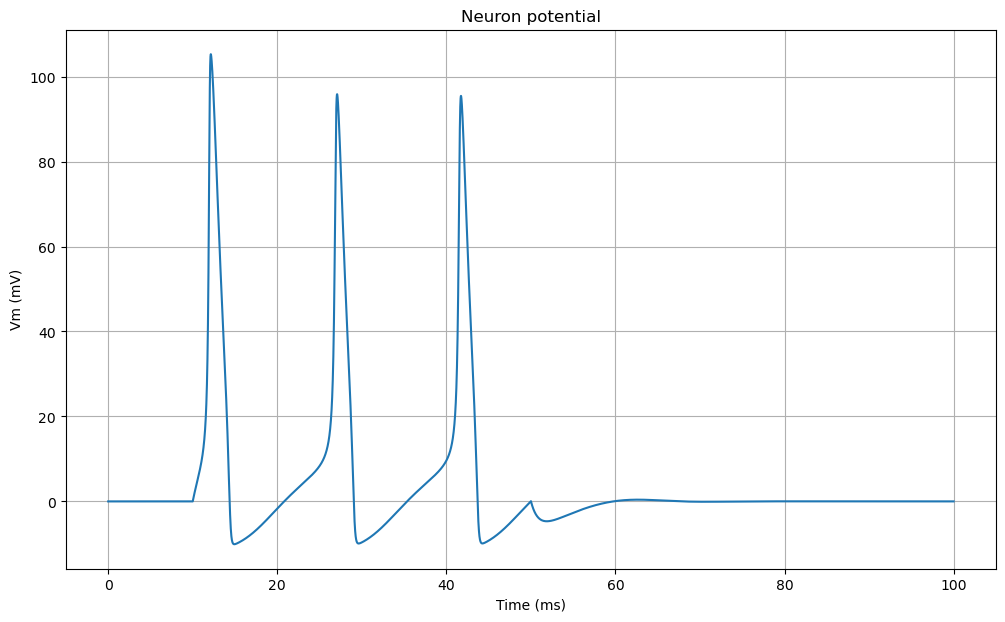

In [18]:


def HH_final(peram):


    gK = peram[0]
    gNa = peram[1]
    tmin=0
    tmax=100
    gL = 0.3
    Cm = 1.0
    VK = -12.0
    VNa = 115.0
    Vl = 10.613
    

    T,Idv = input(100.0, 10.0 ,50.0)

    z = 0
    y = np.array([m_inf,n_inf,h_inf])
    h = 0.01
    
    Y,Z= RK4(y,z,Idv,h, gK, gNa, gL, Cm, VK, VNa, Vl)

    # Potassium ion-channel rate functions

    #return T,Y,Z
    return Z


peram = np.array([36.0, 120.0])

Z = HH_final(peram)

T = np.linspace(0, 100, 10000)

# Neuron potential
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(T, Z)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neuron potential')
plt.grid()